<a href="https://colab.research.google.com/github/diaznugraha03/tugas-tugas/blob/main/Silver_Price_Prediction___LSTM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Menggunakan kode asli diatas tanpa memodifikasi apapun yaitu aktivasi Relu, optimasi Nadam, Batch size 16, dan epoch 10**

**Pada notebook ini, kita akan membangun model deret waktu untuk memprediksi harga emas di masa mendatang, yang dapat sangat berguna bagi para pedagang. Untuk tujuan ini, kita menggunakan data harga emas historis selama 10 tahun (dari 2015 hingga 2025)._**

# Langkah 1: Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from google.colab import drive

# Langkah 2: Membaca Dataset

In [41]:
drive.mount('/content/drive')  # Mount Google Drive
BASE_DIR = "/content/drive/MyDrive/Deep Learning/tugas7/Data Historis Perak Berjangka.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Langkah 3: Menampilkan Dataset

In [42]:
df = pd.read_csv(BASE_DIR)
df

,Date,Price,Open,High,Low,Vol.,Change %
0,19/05/2025,"32,615","32,632","32,730","32,430","9,47K","-0,05%"
1,18/05/2025,"32,632","32,498","32,693","32,435","2,00K","0,86%"
2,16/05/2025,"32,354","32,795","32,865","31,980","40,94K","-1,00%"
3,15/05/2025,"32,680","32,395","32,820","31,780","45,07K","0,73%"
4,14/05/2025,"32,444","33,085","33,150","32,255","47,79K","-1,98%"
...,...,...,...,...,...,...,...
2589,25/05/2015,"16,746","17,050","17,180","16,645","48,46K","-1,79%"
2590,22/05/2015,"17,051","17,140","17,335","16,940","31,25K","-0,47%"
2591,21/05/2015,"17,132","17,100","17,250","17,000","21,29K","0,11%"
2592,20/05/2015,"17,113","17,095","17,280","16,935","34,83K","0,25%"


Seperti yang Anda lihat, kumpulan data tersebut mencakup informasi harga emas harian termasuk harga Pembukaan, Harga Tertinggi dan Terendah harian dan harga akhir setiap hari (Harga) beserta volume transaksi dan perubahan harga setiap hari.


__Informasi Dasar Dataset:__

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594 entries, 0 to 2593
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2594 non-null   object
 1   Price     2594 non-null   object
 2   Open      2594 non-null   object
 3   High      2594 non-null   object
 4   Low       2594 non-null   object
 5   Vol.      2565 non-null   object
 6   Change %  2594 non-null   object
dtypes: object(7)
memory usage: 142.0+ KB


__Semua variabel disimpan sebagai objek.__

# Langkah 4: Persiapan Data

## Langkah 4.1: Pemilihan Subset Fitur
Karena kita tidak akan menggunakan fitur Vol. dan Perubahan % untuk memprediksi Harga, kita akan menghilangkan dua fitur ini:

In [44]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

## Langkah 4.2: Transformasi Data

Fitur tanggal disimpan sebagai objek dalam bingkai data. Untuk meningkatkan kecepatan kalkulasi, kita mengonversi tipe datanya ke datetime dan kemudian mengurutkan fitur ini dalam urutan menaik:

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

<ipython-input-45-ba4bc9a812b5>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



Tanda ", " berlebihan dalam dataset. Pertama, kita hapus tanda tersebut dari seluruh dataset dan kemudian ubah tipe data variabel numerik menjadi float:

In [46]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

Hasil:

In [47]:
df.head()

,Date,Price,Open,High,Low
0,2015-05-19,17071.0,17705.0,17735.0,16870.0
1,2015-05-20,17113.0,17095.0,17280.0,16935.0
2,2015-05-21,17132.0,17100.0,17250.0,17000.0
3,2015-05-22,17051.0,17140.0,17335.0,16940.0
4,2015-05-25,16746.0,17050.0,17180.0,16645.0


## Langkah 4.3: Memeriksa Duplikat
__Tidak ada sampel duplikat dalam fitur Tanggal:__

In [48]:
df.duplicated().sum()

np.int64(0)

## Langkah 4.4: Memeriksa Nilai yang Hilang
__Tidak ada nilai yang hilang dalam dataset:__

In [49]:
df.isnull().sum().sum()

np.int64(0)

# Langkah 5: Memvisualisasikan Data Riwayat Harga Perak

__Membuat Grafik Harga Perak Interaktif:__

In [50]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Tanggal",
                  yaxis_title="Harga Berskala",
                  title={'text': "Data Riwayat Harga Perak", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                    plot_bgcolor='white')

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

# Langkah 6: Membagi Data ke dalam Set Pelatihan dan Pengujian
Karena kita tidak dapat melatih data masa depan dalam data deret waktu, kita tidak boleh membagi data deret waktu secara acak. Dalam pemisahan deret waktu, set pengujian selalu lebih lambat daripada set pelatihan. Kita mempertimbangkan tahun terakhir untuk pengujian dan yang lainnya untuk pelatihan:

In [51]:
test_size = df[df.Date.dt.year==2025].shape[0]
test_size

96

__Silver Price Training and Test Sets Plot:__

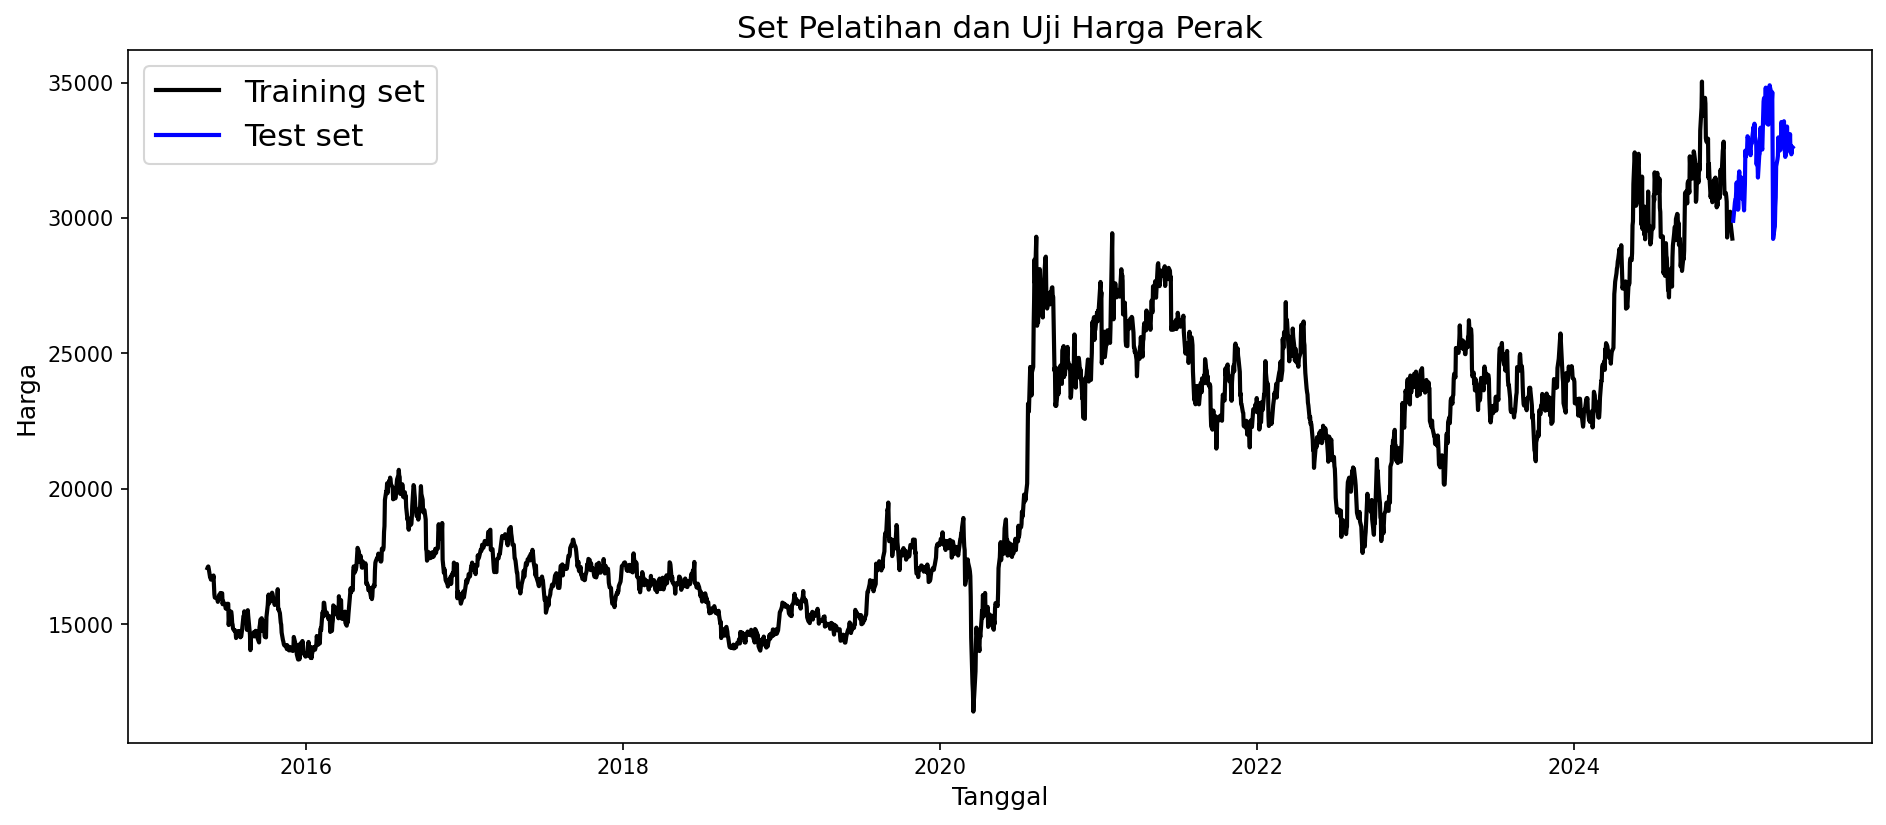

In [52]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='black')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Set Pelatihan dan Uji Harga Perak', fontsize=15)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Langkah 7: Penskalaan Data
Karena kita ingin memprediksi Harga hanya berdasarkan data historisnya, kita menskalakan Harga menggunakan MinMaxScaler untuk menghindari perhitungan intensif:

In [53]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# Langkah 8: Restrukturisasi Data & Buat Jendela Geser
Penggunaan langkah waktu sebelumnya untuk memprediksi langkah waktu berikutnya disebut jendela geser. Dengan cara ini, data deret waktu dapat dinyatakan sebagai pembelajaran terbimbing. Kita dapat melakukannya dengan menggunakan langkah waktu sebelumnya sebagai variabel masukan dan menggunakan langkah waktu berikutnya sebagai variabel keluaran. Jumlah langkah waktu sebelumnya disebut lebar jendela. Di sini kita menetapkan lebar jendela menjadi 60. Oleh karena itu, X_train dan X_test akan menjadi daftar bersarang yang berisi daftar 60 harga cap waktu. y_train dan y_test juga merupakan daftar harga emas yang berisi harga emas hari berikutnya yang sesuai dengan setiap daftar di X_train dan X_test secara berurutan:

In [54]:
window_size = 60

__Training Set:__

In [55]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [56]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [57]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [58]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Langkah 9: Mengonversi Data ke Array Numpy

Sekarang X_train dan X_test adalah daftar bersarang (daftar dua dimensi) dan y_train adalah daftar satu dimensi. Kita perlu mengonversinya menjadi array numpy dengan dimensi yang lebih tinggi, yang merupakan format data yang diterima oleh TensorFlow saat melatih jaringan saraf:

In [59]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [60]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [61]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2438, 60, 1)
y_train Shape:  (2438, 1)
X_test Shape:   (96, 60, 1)
y_test Shape:   (96, 1)


# Langkah 10: Membuat Jaringan LSTM
Kita membangun jaringan LSTM, yang merupakan jenis Jaringan Syaraf Tiruan Berulang yang dirancang untuk memecahkan masalah gradien yang menghilang:

__Model Definition:__

In [62]:
def define_model():
    input1 = Input(shape=(window_size, 1))

    # LSTM Layers with Dropout
    x = LSTM(units=64, return_sequences=True)(input1)
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)

    # Dense Layers
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=dnn_output)
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

model = define_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

__Model Training:__

In [63]:
# Callbacks untuk menghindari overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Training model dengan validasi
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0183
Epoch 1: val_loss improved from inf to 0.00352, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0182 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0029
Epoch 2: val_loss did not improve from 0.00352
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - loss: 0.0029 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0021
Epoch 3: val_loss improved from 0.00352 to 0.00341, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0021 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0019
Epoch 4: val_loss did not improve from 0.00341
138/138 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - loss: 0.0019 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0

# Langkah 11: Evaluasi Model
Selanjutnya, kami mengevaluasi perkiraan deret waktu kami menggunakan metrik MAPE (Mean Absolute Percentage Error):

In [64]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0016
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 


In [65]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [66]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0022776462137699127
Test MAPE: 0.03818287675002858
Test Accuracy: 0.9618171232499714


# Langkah 12: Memvisualisasikan Hasil

__Mengembalikan nilai Harga aktual dan prediksi ke skala utamanya:__

In [67]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Menyelidiki kedekatan harga yang diprediksi oleh model dengan harga sebenarnya:__

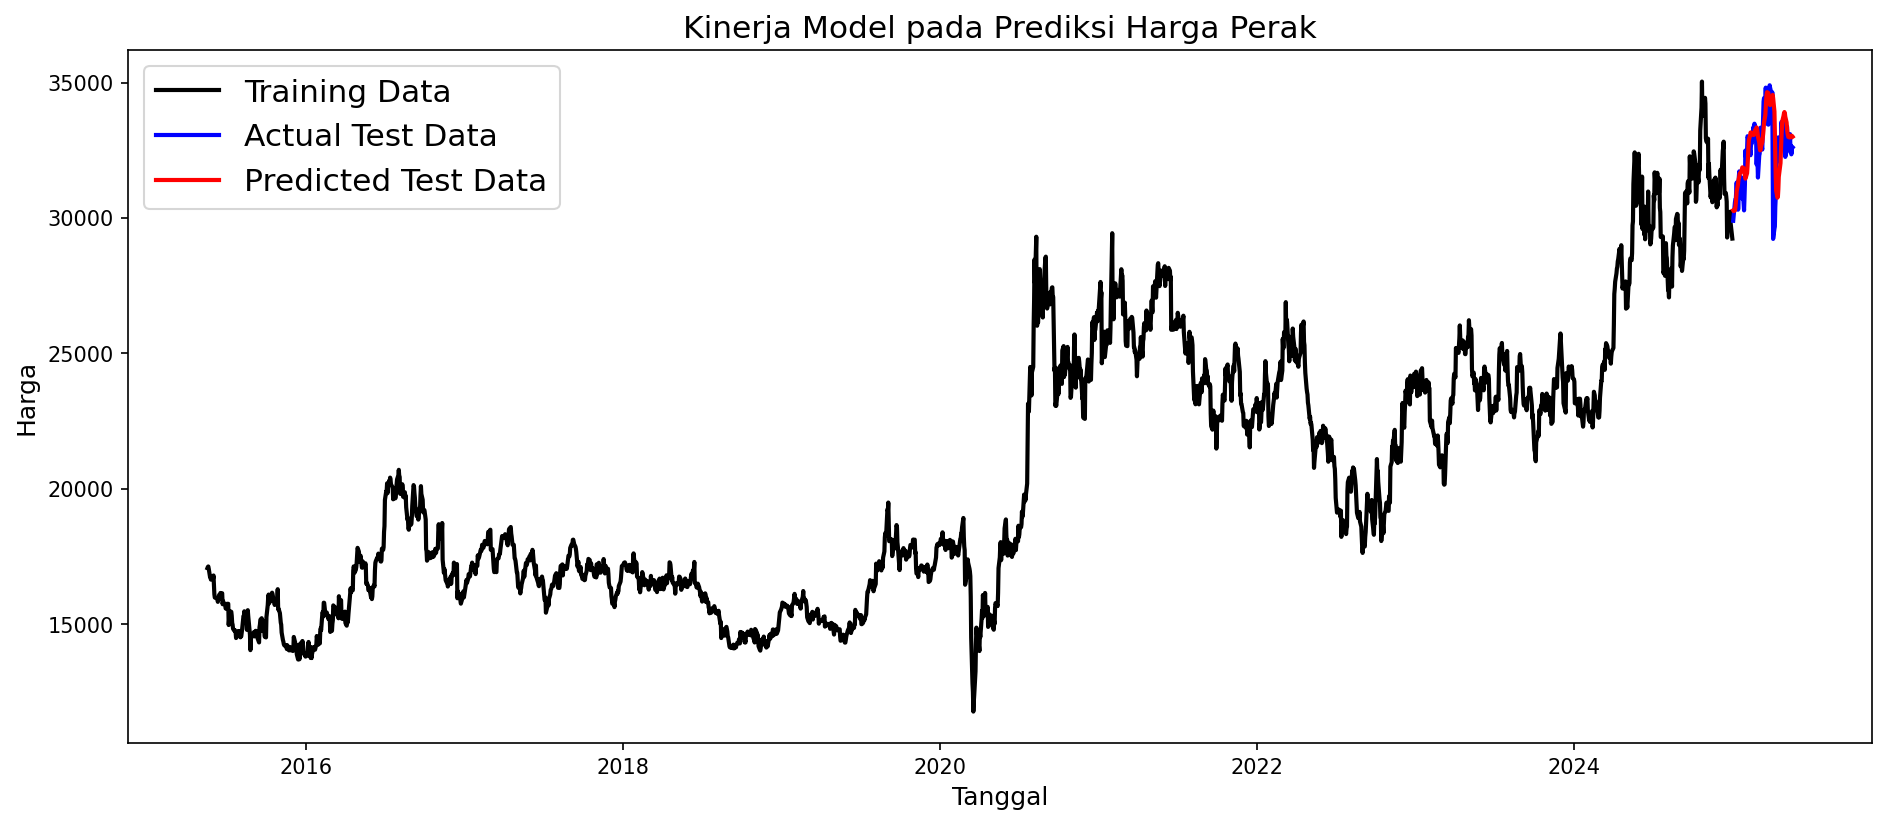

In [68]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='black')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Kinerja Model pada Prediksi Harga Perak', fontsize=15)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

__Menampilkan perbandingan harga yang diprediksi oleh model dengan harga sebenarnya:__

In [69]:
comparison_df = pd.DataFrame({'Tanggal': df['Date'].iloc[-test_size:],
                              'Harga Aktual': y_test_true.flatten(),
                              'Harga Prediksi': y_test_pred.flatten()})

print(comparison_df)

        Tanggal  Harga Aktual  Harga Prediksi
2498 2025-01-02       29900.0    30287.152344
2499 2025-01-03       30065.0    30257.876953
2500 2025-01-06       30583.0    30280.955078
2501 2025-01-07       30686.0    30383.574219
2502 2025-01-08       30690.0    30553.726562
...         ...           ...             ...
2589 2025-05-14       32444.0    33012.718750
2590 2025-05-15       32680.0    33033.406250
2591 2025-05-16       32354.0    33045.265625
2592 2025-05-18       32632.0    33027.128906
2593 2025-05-19       32615.0    33003.675781

[96 rows x 3 columns]


____
# Tugas Modifikasi:

## 1. Ubah fungsi aktivasi menjadi Softmax dan LeakyReLU
## 2. Ubah fungsi optimasi menjadi Adam dan Adamax
## 3. Ubah Batch Size menjadi 32 dan 64
## 4. Ubah Epoch menjadi 100

## Jadi ada lima kombinasi:
## 1. Menggunakan kode asli diatas tanpa memodifikasi apapun yaitu aktivasi Relu, optimasi Nadam, Batch size 16, dan epoch 10
## 2. Menggunakan kode modifikasi yaitu Aktivasi Softmax, optimasi Adam, Batch size 32 dan epoch 100
## 3. Menggunakan kode modifikasi yaitu Aktivasi Softmax, optimasi Adamax, Batch size 64 dan epoch 100
## 4. Menggunakan kode modifikasi yaitu Aktivasi LeakyReLU, optimasi Adam, Batch size 32 dan epoch 100
## 5. Menggunakan kode modifikasi yaitu Aktivasi LeakyReLU, optimasi Adamax, Batch size 64 dan epoch 100

## Masing-masing kelompok menggunakan dataset yang berbeda minimal 10 tahun terakhir (Dataset dapat didownload dari web https://id.investing.com/)
https://id.investing.com/equities/facebook-inc-historical-data